In [32]:


import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow

import sklearn.metrics as sm
from utils.machine_learning import one_hot_decoder

fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(meg='grad')
# print(epochs.info)
print(tf.__version__)
import sys
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)
from utils.data_management import *
# print(dict2str(vars(mneflow)))


2.8.0


In [2]:
mne.set_log_level(verbose='CRITICAL')
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
print(epochs.info)
epochs = epochs.pick_types(meg='grad')

X = np.array([])
Y = list()
for i, epochs in enumerate(epochs_list):
    data = epochs.get_data()
    if i == 0:
        X = data.copy()
    else:
        X = np.append(X, data, axis=0)
    Y += [i for _ in range(data.shape[0])]

Y = np.array(Y)

sample_matrix = X[0].copy()

X = np.array([X[i, epochs._channel_type_idx['grad'], :] for i, _ in enumerate(X)])


<Info | 22 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 acq_stim: 5 10.000000 500.000000 6 10.000000 500.000000
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 GRAD, 102 MAG, 9 STIM, 1 EOG
 custom_ref_applied: False
 description: Vectorview system at BioMag
 dev_head_t: MEG device -> head transform
 dig: 21 items (3 Cardinal, 4 HPI, 14 Extra)
 events: 1 item (list)
 experimenter: neuromag
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2011-04-26 11:33:18 UTC
 meas_id: 4 items (dict)
 nchan: 316
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: grad_ssp_upright.fif : PCA-v1: on, grad_ssp_upright.fif : ...
 sfreq: 600.6 Hz
 subject_info: 9 items (dict)
>


In [3]:
#Specify import options
import_opt = dict(savepath='../tfr/',
                  out_name='mne_sample_epochs',
                  fs=600,
                  input_type='trials',
                  target_type='int',
                  picks={'meg':'grad'},
                  scale=True,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  decimate=None,
                  scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
                #   n_folds=5,  # validation set size set to 20% of all data
                  n_folds=5,
                  overwrite=True,
                  segment=False,
                #   test_set='holdout'
)


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords((X, Y), **import_opt)  

# Preprocessed: (940, 1, 361, 204) (940, 8) folds: 1 x 940
# Preprocessed: (940, 1, 361, 204) (940, 8) folds: 2 x 470
# Preprocessed: (940, 1, 361, 204) (940, 8) folds: 5 x 188

importing from tuple
input shapes: X- (940, 204, 361) targets- (940, 1)
Preprocessing:
Scaling to interval 0.0 - 60.0
Splitting sets
Preprocessed: (940, 1, 361, 204) (940, 8) folds: 5 x 188
Prepocessed sample shape: (1, 361, 204)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


In [4]:
dataset = mneflow.Dataset(meta, train_batch=100)

In [5]:
# specify model parameters
lf_params = dict(n_latent=32, #number of latent factors
                  filter_length=17, #convolutional filter length in time samples
                  nonlin = tf.nn.relu,
                  padding = 'SAME',
                  pooling = 5,#pooling factor
                  stride = 5, #stride parameter for pooling layer
                  pool_type='max',
                  model_path = import_opt['savepath'],
                  dropout = .5,
                  l1_scope = ["weights"],
                  l1=3e-3)

model = mneflow.models.LFCNN(dataset, lf_params)
model.build()

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 361, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 361, 32)
Setting reg for fc, to l1
Built: fc input: (None, 1, 37, 32)
Input shape: (1, 361, 204)
y_pred: (None, 8)
Initialization complete!


Epoch 1/25
100/100 - 4s - loss: 5.0787 - cat_ACC: 0.1556 - val_loss: 4.5301 - val_cat_ACC: 0.2394 - 4s/epoch - 38ms/step
Epoch 2/25
100/100 - 3s - loss: 4.4989 - cat_ACC: 0.2504 - val_loss: 4.1425 - val_cat_ACC: 0.3351 - 3s/epoch - 29ms/step
Epoch 3/25
100/100 - 3s - loss: 4.0593 - cat_ACC: 0.3351 - val_loss: 3.7904 - val_cat_ACC: 0.4096 - 3s/epoch - 29ms/step
Epoch 4/25
100/100 - 3s - loss: 3.6571 - cat_ACC: 0.4249 - val_loss: 3.5069 - val_cat_ACC: 0.4521 - 3s/epoch - 29ms/step
Epoch 5/25
100/100 - 3s - loss: 3.3556 - cat_ACC: 0.4949 - val_loss: 3.2445 - val_cat_ACC: 0.5426 - 3s/epoch - 28ms/step
Epoch 6/25
100/100 - 3s - loss: 3.0240 - cat_ACC: 0.5817 - val_loss: 2.9920 - val_cat_ACC: 0.6223 - 3s/epoch - 27ms/step
Epoch 7/25
100/100 - 3s - loss: 2.7734 - cat_ACC: 0.6507 - val_loss: 2.7470 - val_cat_ACC: 0.6968 - 3s/epoch - 29ms/step
Epoch 8/25
100/100 - 3s - loss: 2.5064 - cat_ACC: 0.7229 - val_loss: 2.5261 - val_cat_ACC: 0.7553 - 3s/epoch - 30ms/step
Epoch 9/25
100/100 - 3s - loss: 

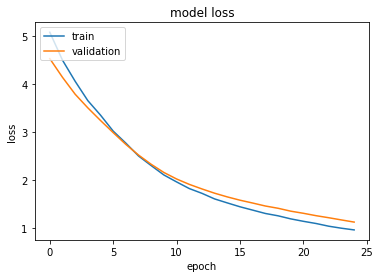

In [6]:
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

In [7]:
# X = np.transpose(np.expand_dims(X, axis = 1), (0, 1, 3, 2))
y_t, y_p = model.predict(model.dataset.train)

print(y_p.shape)

y_t, y_p = model.predict(model.dataset.val)

print(y_p.shape)



(100, 8)
(188, 8)


In [36]:
# X = np.transpose(np.expand_dims(X, axis = 1), (0, 1, 3, 2))
# y_t, y_p = model.predict(model.dataset.train)

# print(y_p.shape)

y_t_val, y_p_val = model.predict(model.dataset.val)

print(
    'val acc',
    sm.accuracy_score(
        one_hot_decoder(y_t_val),
        one_hot_decoder(y_p_val),
    )
)

y_t_train, y_p_train = model.predict(model.dataset.train)

print(
    'train acc',
    sm.accuracy_score(
        one_hot_decoder(y_t_train),
        one_hot_decoder(y_p_train),
    )
)

y_t = np.concatenate([y_t_val, y_t_train], axis=0)
y_p = np.concatenate([y_p_val, y_p_train], axis=0)


print(
    'total acc',
    sm.accuracy_score(
        one_hot_decoder(y_t),
        one_hot_decoder(y_p),
    )
)

val acc 0.7393617021276596
train acc 0.94
total acc 0.8090277777777778


In [10]:
model.evaluate(model.dataset.val)

1/1 [==============================] - 0s 206ms/step - loss: 1.1331 - cat_ACC: 0.8777


(1.1331031322479248, 0.8776595592498779)

In [ ]:
y_t_val, y_p_val = model.predict(model.dataset.val)

y_t_train, y_p_train = model.predict(model.dataset.train)



y_t = np.concatenate([y_t_val, y_t_train], axis=0)
y_p = np.concatenate([y_p_val, y_p_train], axis=0)

In [6]:
model.compute_patterns()
f1 = model.plot_patterns('Vectorview-grad', sorting='output_corr')


Computing patterns: No path specified, using validation dataset (Default)


ValueError: Info (204) and data (0) must have same number of channels.